# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
!pip install matplotlib --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression - Assignment' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'Gangadhar Bhuvan' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
905,26,female,28.47435,2,no,5020.610595
1256,51,female,35.29345,3,no,12580.411965
970,50,female,27.31520,3,no,11772.906640
991,38,female,26.99995,2,no,7859.348915
177,54,male,28.32400,1,no,11479.705600


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [10]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [11]:
# input_cols = dataframe.columns[:-1]
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [12]:
# import numpy as np
# categorical_cols = dataframe.dtypes[dataframe.dtypes == np.object]
categorical_cols = ["sex", "smoker"]
print(categorical_cols)

['sex', 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [13]:
# output_cols = dataframe.columns[-1]
output_cols = ['charges']
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

Minimum charge: 1234.06
Maximum charge: 70147.47
Average charge: 14720.77
Appropriate average charge: 10352.11


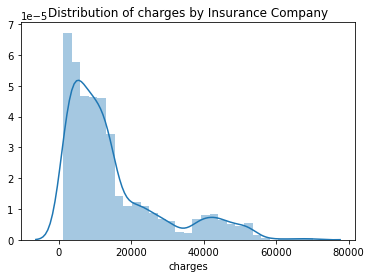

In [14]:
# Write your answer here
min_charge = dataframe['charges'].min()
print('Minimum charge: %0.2f'% min_charge)
max_charge = dataframe['charges'].max()
print('Maximum charge: %0.2f'% max_charge)
average_charge = dataframe['charges'].mean() # Considering mean is the appropriate measure of central tendency in this case
print('Average charge: %0.2f'% average_charge)

!pip install seaborn
import seaborn as sns
plt.title("Distribution of charges by Insurance Company")
sns.distplot(dataframe.charges)

# Since the data is positively skewed, appropriate measure for average will be median
import statistics as stats
median_charge = stats.median(dataframe.charges)
print('Appropriate average charge: %0.2f' % median_charge)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [15]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [16]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[26.     ,  0.     , 28.47435,  2.     ,  0.     ],
        [51.     ,  0.     , 35.29345,  3.     ,  0.     ],
        [50.     ,  0.     , 27.3152 ,  3.     ,  0.     ],
        ...,
        [18.     ,  1.     , 29.488  ,  3.     ,  0.     ],
        [29.     ,  0.     , 31.1467 ,  2.     ,  0.     ],
        [50.     ,  1.     , 30.0409 ,  3.     ,  0.     ]]),
 array([[ 5020.610595],
        [12580.411965],
        [11772.90664 ],
        ...,
        [ 3830.0548  ],
        [ 5415.20749 ],
        [11660.60313 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [17]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [18]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [19]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [20]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
print(val_size, train_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

190 1081


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [21]:
batch_size = 32

In [22]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [23]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[34.0000,  1.0000, 24.5119,  1.0000,  0.0000],
        [54.0000,  1.0000, 33.1837,  2.0000,  1.0000],
        [21.0000,  1.0000, 25.2491,  0.0000,  0.0000],
        [45.0000,  0.0000, 30.8363,  0.0000,  0.0000],
        [50.0000,  0.0000, 27.2764,  3.0000,  0.0000],
        [41.0000,  1.0000, 31.2340,  2.0000,  0.0000],
        [45.0000,  1.0000, 20.7337,  0.0000,  0.0000],
        [35.0000,  1.0000, 23.6874,  3.0000,  1.0000],
        [26.0000,  1.0000, 34.3574,  0.0000,  0.0000],
        [19.0000,  1.0000, 33.8530,  0.0000,  1.0000],
        [36.0000,  1.0000, 26.7235,  3.0000,  0.0000],
        [33.0000,  1.0000, 32.4368,  5.0000,  0.0000],
        [47.0000,  1.0000, 35.1140,  1.0000,  0.0000],
        [57.0000,  0.0000, 36.8600,  2.0000,  0.0000],
        [28.0000,  1.0000, 29.9487,  0.0000,  0.0000],
        [25.0000,  0.0000, 40.8661,  1.0000,  0.0000],
        [58.0000,  1.0000, 27.7372,  0.0000,  0.0000],
        [44.0000,  0.0000, 31.3698,  1.0000,  0.0000],
  

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [24]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [25]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                   
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                         
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)         
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [26]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [27]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4310,  0.0722,  0.0021, -0.0751, -0.0510]], requires_grad=True),
 Parameter containing:
 tensor([0.1715], requires_grad=True)]

One final commit before we train the model.

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [28]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [29]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15666.8505859375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [30]:
epochs = 100
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15503.2354
Epoch [40], val_loss: 15339.6494
Epoch [60], val_loss: 15176.0400
Epoch [80], val_loss: 15012.4531
Epoch [100], val_loss: 14848.8564


In [31]:
epochs = 150
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13242.2939
Epoch [40], val_loss: 11880.7646
Epoch [60], val_loss: 10857.5303
Epoch [80], val_loss: 10129.5312
Epoch [100], val_loss: 9641.1240
Epoch [120], val_loss: 9330.2568
Epoch [140], val_loss: 9155.6602
Epoch [150], val_loss: 9099.7266


In [32]:
epochs = 600
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8859.5293
Epoch [40], val_loss: 8790.6963
Epoch [60], val_loss: 8729.9189
Epoch [80], val_loss: 8675.6475
Epoch [100], val_loss: 8625.4561
Epoch [120], val_loss: 8583.6963
Epoch [140], val_loss: 8548.7686
Epoch [160], val_loss: 8522.6631
Epoch [180], val_loss: 8504.3975
Epoch [200], val_loss: 8497.1875
Epoch [220], val_loss: 8494.4727
Epoch [240], val_loss: 8498.2842
Epoch [260], val_loss: 8500.4805
Epoch [280], val_loss: 8501.5020
Epoch [300], val_loss: 8502.7471
Epoch [320], val_loss: 8505.1016
Epoch [340], val_loss: 8505.5000
Epoch [360], val_loss: 8505.8477
Epoch [380], val_loss: 8507.0615
Epoch [400], val_loss: 8506.6719
Epoch [420], val_loss: 8507.0479
Epoch [440], val_loss: 8506.8984
Epoch [460], val_loss: 8506.0205
Epoch [480], val_loss: 8505.5195
Epoch [500], val_loss: 8504.7725
Epoch [520], val_loss: 8503.4697
Epoch [540], val_loss: 8502.8721
Epoch [560], val_loss: 8502.0215
Epoch [580], val_loss: 8501.1416
Epoch [600], val_loss: 8500.4521


**Q: What is the final validation loss of your model?**

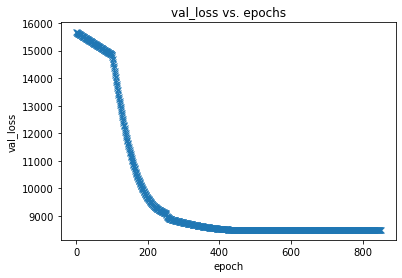

In [33]:
losses = [r['val_loss'] for r in [result] +  history3 + history4 + history5]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [34]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions =  model(inputs)               # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [35]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([21.0000,  0.0000, 21.4709,  0.0000,  0.0000])
Target: tensor([2844.4358])
Prediction: tensor([3845.2402])


In [38]:
input, target = val_ds[30]
predict_single(input, target, model)

Input: tensor([54.0000,  0.0000, 30.9430,  1.0000,  0.0000])
Target: tensor([12021.7344])
Prediction: tensor([12313.9941])


In [39]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([34.0000,  0.0000, 29.3037,  1.0000,  1.0000])
Target: tensor([48338.2656])
Prediction: tensor([6858.3198])


Are you happy with your model's predictions? Try to improve them further.